In [1]:
"""
1. Mean
2. DBA
3. Soft-dtw

on simulated signals
"""

'\n1. Mean\n2. DBA\n3. Soft-dtw\n\non simulated signals\n'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from Tutorial.Dataset  import load_scg
from DTW import _traceback, dtwPlotTwoWay
from tqdm import tqdm
from tslearn.barycenters import softdtw_barycenter
from numpy import zeros, inf

from DBA import performDBA_

In [3]:
def load_simulated_data(noise_level=0):
    signals_train, labels_train, duration, fs = load_scg(noise_level, 'train')
    signals_test, labels_test, _, _ = load_scg(noise_level, 'test')

    def filter_signals(signals, labels):
        idx = np.any(signals > 1, axis=1)
        return signals[~idx], labels[~idx]

    filtered_signals_train, filtered_labels_train = filter_signals(signals_train, labels_train)
    filtered_signals_test, filtered_labels_test = filter_signals(signals_test, labels_test)

    print(filtered_signals_train.shape, filtered_labels_test.shape)
    return filtered_labels_train, filtered_labels_test, filtered_signals_train, filtered_signals_test

In [36]:
def Cauchy(mu_X, sigma_X, mu_Y, sigma_Y, num_samples = 1000):
    X = np.random.normal(mu_X, sigma_X, num_samples)
    Y = np.random.normal(mu_Y, sigma_Y, num_samples)
    Z = X / Y
    return np.mean(Z), np.std(Z)

In [37]:
def segmentation(signal, rpeak):
    begin, end = 0, 0
    margin = rpeak[0]
    pieces = []

    for num in range(1, len(rpeak)):
        begin = end
        end = rpeak[num] - margin
        pieces.append(signal[begin: end])
    Nmax = 0
    for piece in pieces:
        Nmax = max(Nmax, piece.shape[0])
    pieces_padded = []
    for piece in pieces:
        N = Nmax - piece.shape[0]
        pieces_padded.append(np.pad(piece, (0, N), 'constant'))
    return pieces_padded


def get_features(template, tolerance, h, d):
    template_peaks_, _ = find_peaks(template, height=np.max(template) * h, distance=len(template) * d)
    template_peaks = []

    if len(template_peaks_) == 2:
        template_peaks = template_peaks_
    elif len(template_peaks_) > 2:
        mmax = np.argmax(template[template_peaks_])
        template_peaks.append(template_peaks_[mmax])
        template_peaks_ = np.delete(template_peaks_, mmax)
        mmax2 = np.argmax(template[template_peaks_])
        template_peaks.append(template_peaks_[mmax2])
    elif len(template_peaks_) < 2:
        # plt.figure()
        # plt.plot(template)
        # plt.scatter(template_peaks_, template[template_peaks_])
        # plt.show()
        return None

    Nmax = len(template)

    dis12 = template_peaks[1] - template_peaks[0]
    dis21 = Nmax - dis12
    A0 = template[template_peaks[0]]
    A1 = template[template_peaks[1]]

    show = False

    if show:
        plt.figure()
        plt.plot(template)
        plt.scatter(template_peaks, template[template_peaks])
        # plt.title(f'dis12/dis21:{dis12/dis21}, A0/A1:{A0/A1}')
        plt.show()

    S_feature, weight = Cauchy(A0, tolerance[template_peaks[0]], A1, tolerance[template_peaks[1]])
    return [dis12/dis21, A0/A1, S_feature, weight]


In [38]:
from tslearn.metrics import SquaredEuclidean, SoftDTW

def traceback(D):
    i, j = np.array(D.shape) - 2
    p, q = [i], [j]
    while (i > 0) or (j > 0):
        tb = np.argmin((D[i, j], D[i, j + 1], D[i + 1, j]))
        if tb == 0:
            i -= 1
            j -= 1
        elif tb == 1:
            i -= 1
        else:  # (tb == 2):
            j -= 1
        p.insert(0, i)
        q.insert(0, j)
    return np.array(p), np.array(q)

def _softdtw_func_(Z, X, barycenter, gamma):
    # Compute objective value and grad at Z.

    Z = Z.reshape(barycenter.shape)
    G = np.zeros_like(Z)
    obj = 0

    for i in range(len(X)):
        D = SquaredEuclidean(Z, X[i])
        sdtw = SoftDTW(D, gamma=gamma)
        value = sdtw.compute()
        matrix = sdtw.R_
        m, n = len(Z), len(X[i])
        # print(m, n)
        # print(matrix.shape)
        # print(value, matrix[m, n])

        # print(matrix[:-1, :-1])
        matrix[0, 1:] = np.inf * -1
        matrix[1:, 0] = np.inf * -1
        path1, path2 = traceback(matrix[:-1, :-1] * -1)

        plt.imshow(matrix[:-1, :-1] * -1, cmap='viridis', interpolation='nearest')
        plt.colorbar()
        plt.show()

        for i, j in zip(path1, path2):
            matrix[i, j] = -1000

        plt.imshow(matrix[:-1, :-1] * -1, cmap='viridis', interpolation='nearest')
        plt.colorbar()
        plt.show()
        print(path1.shape, path2.shape)
        print(path1, path2)
        break

In [39]:
def extract_features(signals, labels, alpha,  h, d, echo):
    idxs = []
    Template_features = []

    for cnt, signal in tqdm(enumerate(signals)):
        hr = labels[cnt, 2]
        large_peaks, _ = find_peaks(signal, height=np.max(signal)*0.3, distance=5000//(hr*alpha))
        pieces = segmentation(signal, large_peaks)
        # template_soft = softdtw_barycenter(pieces).ravel()
        template_dba, tolerance= performDBA_(pieces)

        # plt.figure(figsize=(12, 3))
        # plt.plot(template_dba, linewidth=2, color='r', label='DBA')
        # plt.plot(template_dba + tolerance, linewidth=1, color='gray', label='DBA_up')
        # plt.plot(template_dba - tolerance, linewidth=1, color='gray', label='DBA_down')
        # plt.legend()
        # plt.show()

        features = get_features(template_dba, tolerance, h, d)
        if features is not None:
            idxs.append(cnt)
        Template_features.append(features)
        if cnt > echo:
            break
    return np.array(Template_features), np.array(idxs)

In [54]:
if __name__=='__main__':
    labels_0_train, labels_0_test, signals_0_train, signals_0_test = load_simulated_data(0)

    echo1 = 500
    echo2 = 300
    template_features_train, idxs_train = extract_features(signals_0_train,labels_0_train,1,0.1,0.15, echo1)
    template_features_test, idxs_test = extract_features(signals_0_test, labels_0_test,1,0.12,0.12, echo2)

(4718, 1000) (2822, 6)


79it [02:01,  1.54s/it]


KeyboardInterrupt: 

In [50]:
import numpy as np
import matplotlib.pyplot as plt

def calc_mae(gt, pred):
    return np.mean(abs(np.array(gt) - np.array(pred)))

def plot_2vectors(label, pred, save=False, name=None, path=None):
    """lsit1: label, list2: prediction"""

    list1 = label
    list2 = np.array(pred)
    if list2.ndim == 2:
        mae = calc_mae(list1, list2[:, 0])
    else:
        mae = calc_mae(list1, list2)

    sorted_id = sorted(range(len(list1)), key=lambda k: list1[k])

    plt.clf()
    plt.text(0, np.min(list2), f'MAE={mae}')

    plt.scatter(np.arange(list2.shape[0]), list2[sorted_id], s=1, alpha=0.5, label=f'{name} prediction', color='blue')
    plt.scatter(np.arange(list1.shape[0]), list1[sorted_id], s=1, alpha=0.5, label=f'{name} label', color='red')
    plt.legend(loc='lower right')

    if save:
        if path is None:
            raise ValueError("If save is True, 'path' argument must be provided.")
        plt.savefig(f'{path}.jpg', dpi=300)
        print(f'Saved plot to {path}.jpg')

    plt.show()


In [51]:
template_features_train[:, 0].shape, labels_0_train[:echo1+2, 4].shape, template_features_test[:, 0].shape, labels_0_test[:echo1+2, 4].shape

((202,), (202,), (122,), (202,))

In [52]:
template_features_train[:, 3], np.exp(-1 * template_features_train[:, 3])

(array([3.94135177e-01, 1.79691935e+00, 9.47747424e-02, 6.29717802e-01,
        4.19870697e-01, 1.37021194e+00, 1.24478512e+01, 6.93303944e-01,
        5.55641000e-01, 4.21774681e-01, 4.93070331e-01, 2.17277544e-01,
        3.26995307e-01, 9.41473541e+00, 3.20722679e-01, 1.24085719e+00,
        1.32814156e-01, 6.03645362e-01, 3.55901128e-02, 7.80132335e-01,
        5.88865945e-01, 1.58184559e+00, 1.36157604e+00, 9.00904008e-01,
        1.36116211e-01, 5.73545072e-01, 6.73853378e-02, 1.39848432e+00,
        4.81223343e-02, 1.07803070e+00, 5.01024056e-01, 1.31766777e+00,
        2.71030536e-01, 2.73379244e-02, 4.77985503e-01, 1.93795307e+00,
        2.15442940e-01, 8.11527030e+01, 4.11358392e+00, 1.98929615e-01,
        8.55864629e-01, 3.29398221e-01, 8.54405670e-01, 2.25646301e+00,
        2.70372741e-01, 8.55171513e-02, 5.29877843e-01, 4.08916020e-02,
        5.38372263e-02, 7.34577657e-01, 2.98201265e-01, 1.12323773e+00,
        3.06531098e-01, 6.98766966e-01, 1.74631831e+00, 2.524037

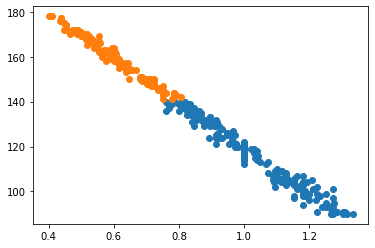

2.0050404932660304


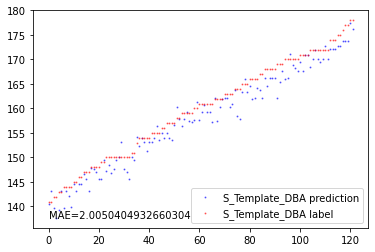

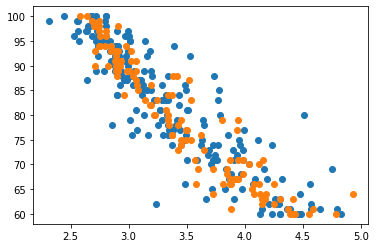

3.5278296179355855


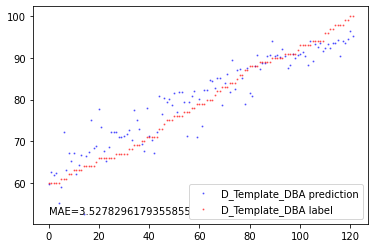

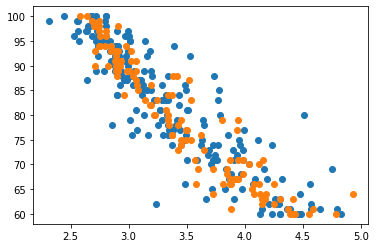

3.309798182684464


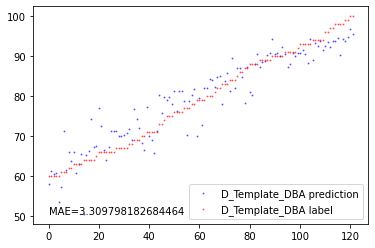

In [53]:
from sklearn.linear_model import LinearRegression as LR
# from Code.Tutorial.utils import plot_2vectors

def plot_plot(features_train, features_test, labels_train, labels_test, title, weight=None):
    plt.figure()
    plt.scatter(np.array(features_train), labels_train)
    plt.scatter(np.array(features_test), labels_test)
    plt.show()

    if weight is None:
        reg = LR().fit(np.array(features_train).reshape(-1, 1), labels_train)
    else:
        reg = LR().fit(np.array(features_train).reshape(-1, 1), labels_train, sample_weight=weight)

    yhat = reg.predict(np.array(features_test).reshape(-1, 1))
    print(np.mean(np.abs(yhat - labels_test)))

    plot_2vectors(labels_test, yhat, False, title)

plot_plot(template_features_train[:, 0],template_features_test[:, 0],labels_0_train[:echo1+2, 4],labels_0_test[:echo2+2, 4],'S_Template_DBA')
plot_plot(template_features_train[:, 1],template_features_test[:, 1],labels_0_train[:echo1+2, 5],labels_0_test[:echo2+2, 5],'D_Template_DBA')
plot_plot(template_features_train[:, 1],template_features_test[:, 1],labels_0_train[:echo1+2, 5],labels_0_test[:echo2+2, 5],'D_Template_DBA', np.exp(-1 * template_features_train[:, 3]))

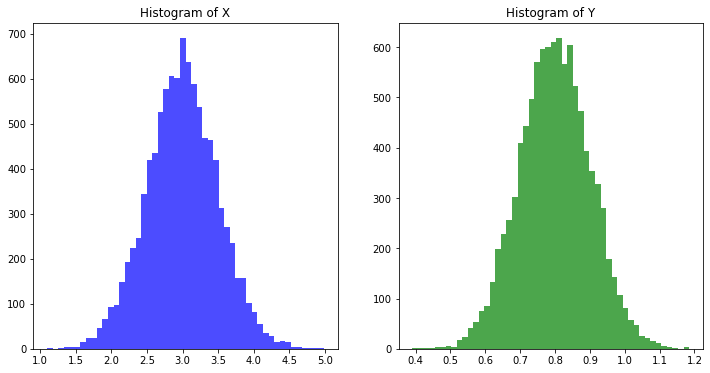

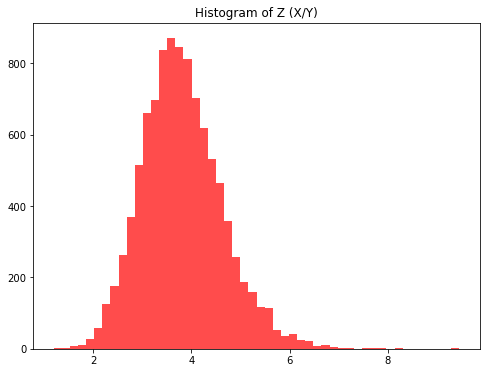

3.8133761157113533 0.8179497556362898
3.75


In [16]:
import numpy as np
import matplotlib.pyplot as plt

# 设置正态分布的参数
mu_X, sigma_X = 3, 0.5  # 正态分布X的均值和标准差
mu_Y, sigma_Y = 0.8, 0.1  # 正态分布Y的均值和标准差

# 模拟生成正态分布的样本
num_samples = 10000
X = np.random.normal(mu_X, sigma_X, num_samples)
Y = np.random.normal(mu_Y, sigma_Y, num_samples)

# 计算正态分布的比值
Z = X / Y

# 绘制直方图
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title('Histogram of X')
plt.hist(X, bins=50, color='blue', alpha=0.7)

plt.subplot(1, 2, 2)
plt.title('Histogram of Y')
plt.hist(Y, bins=50, color='green', alpha=0.7)

plt.show()

# 绘制柯西分布的比值
plt.figure(figsize=(8, 6))
plt.title('Histogram of Z (X/Y)')
plt.hist(Z, bins=50, color='red', alpha=0.7)
plt.show()

print(np.mean(Z), np.std(Z))
print(3 / 0.8)